In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import numpy as np
import os
import zipfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.11.0


In [12]:
# Unzip data
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [14]:
SEED = 2405
tf.random.set_seed(SEED)

In [15]:
IMAGE_DIR = './train'
TEST_DIR = './test1'
filenames = os.listdir(IMAGE_DIR)
labels = [x.split(".")[0] for x in filenames]
df = pd.DataFrame({"filename": filenames, "label": labels})
df.head()

filename label
0  cat.8744.jpg   cat
1  dog.8004.jpg   dog
2  dog.1688.jpg   dog
3  cat.9631.jpg   cat
4  cat.5090.jpg   cat

In [16]:
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({"filename": test_filenames})
test_df.head()

filename
0  1829.jpg
1  7732.jpg
2  9142.jpg
3  4420.jpg
4  9687.jpg

In [17]:
df.label.value_counts()

cat    12500
dog    12500
Name: label, dtype: int64

In [18]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(train_df.label.value_counts())
print(val_df.label.value_counts())

dog    10020
cat     9980
Name: label, dtype: int64
cat    2520
dog    2480
Name: label, dtype: int64


In [19]:
train_df.head()

filename label
0  cat.11499.jpg   cat
1   cat.9161.jpg   cat
2   cat.8733.jpg   cat
3   cat.3319.jpg   cat
4   dog.3542.jpg   dog

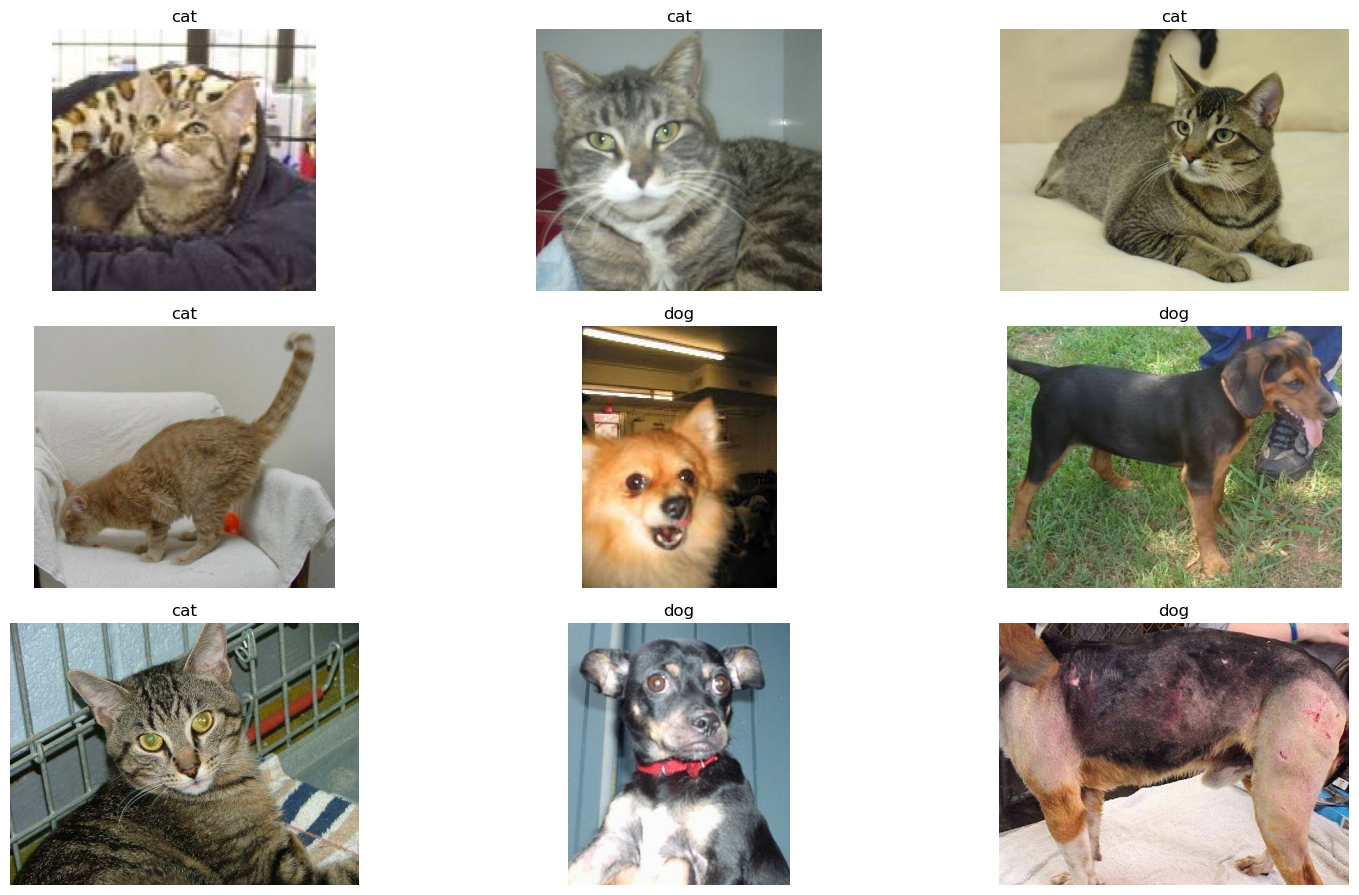

In [20]:
plt.figure(figsize=(15,15))
for i in range(0, 9):
    plt.subplot(5,3,i+1)
    filename, label = train_df.iloc[i]
    img = cv2.imread(os.path.join(IMAGE_DIR, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [137]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.layers[-1].output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

In [121]:
adam = optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss = "categorical_crossentropy", metrics=["accuracy"])

NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
earlystoper = EarlyStopping(monitor="val_loss", patience=5)
checkpointer = ModelCheckpoint(filepath="../working/resnet50best.hdf5", monitor='val_loss', save_best_only=True, mode='auto')
callbacks = [earlystoper, checkpointer]

In [ ]:
batch_size = 100
W, H = 100, 100
epochs = 10

In [ ]:
# Train generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_dataframe(train_df, IMAGE_DIR, x_col="filename", y_col="label",
                                                    target_size=(W,H), class_mode="categorical",
                                                   batch_size=batch_size, shuffle=True, seed=SEED)
# Validation generator
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename", y_col="label",
                                               target_size=(W,H), class_mode="categorical",
                                                batch_size=batch_size)

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=20,
    steps_per_epoch=20,
    callbacks=callbacks
)

In [138]:
model.load_weights("../working/resnet50best.hdf5")

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [127]:
# Feat Map
# get the symbolic outputs of each "key" layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name, layer)
# dense 2 and activation 2 are extra

input_3 <keras.engine.input_layer.InputLayer object at 0x726d303a7950>
conv1_pad <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x726d3a0b0390>
conv1_conv <keras.layers.convolutional.conv2d.Conv2D object at 0x726d40ba2dd0>
pool1_pad <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x726d3a0f4e50>
pool1_pool <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x726d3965e350>
conv2_block1_preact_bn <keras.layers.normalization.batch_normalization_v1.BatchNormalization object at 0x726d316d2910>
conv2_block1_preact_relu <keras.layers.core.activation.Activation object at 0x726d303a76d0>
conv2_block1_1_conv <keras.layers.convolutional.conv2d.Conv2D object at 0x726d324d9d50>
conv2_block1_1_bn <keras.layers.normalization.batch_normalization_v1.BatchNormalization object at 0x726d35f0e5d0>
conv2_block1_1_relu <keras.layers.core.activation.Activation object at 0x726d3a129250>
conv2_block1_2_pad <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x72

In [43]:
# import tensorflow._api.v2.compat.v1 as tf

# tf.disable_v2_behavior()

11722.jpg
(360, 241, 3)
(200, 200, 3)


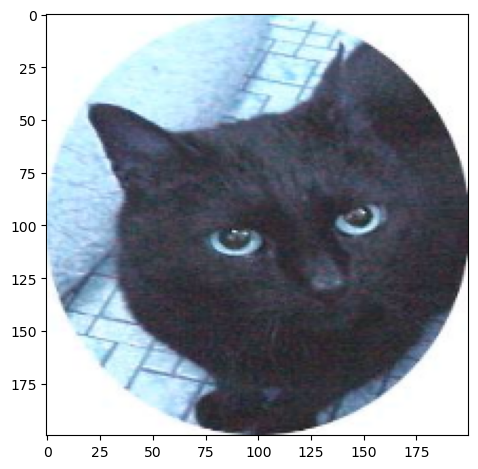

In [44]:
filename = test_df.iloc[23]['filename']
print(filename)
img1 = cv2.imread(os.path.join(TEST_DIR, filename))
print(img1.shape)
img1 = cv2.resize(img1, (200, 200))
print(img1.shape)
plt.imshow(img1)
# plt.title(label)
plt.tight_layout()
plt.show()
img = np.expand_dims(img1, axis=0)
img = preprocess_input(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

4572.jpg
(373, 500, 3)
(200, 200, 3)


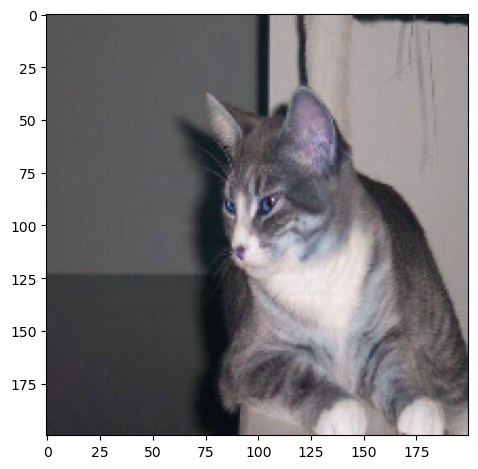

In [54]:
filename = test_df.iloc[29]['filename']
print(filename)
img1 = cv2.imread(os.path.join(TEST_DIR, filename))
print(img1.shape)
img1 = cv2.resize(img1, (200, 200))
print(img1.shape)
plt.imshow(img1)
plt.tight_layout()
plt.show()
img = np.expand_dims(img1, axis=0)
img = preprocess_input(img)

In [55]:
# util function to convert a tensor into a valid image
def tensor2image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.2
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [56]:
pred = model.predict(img)
print(pred)

[[0.06651579 0.9334842 ]]


In [57]:
print(model.input)

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)


(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


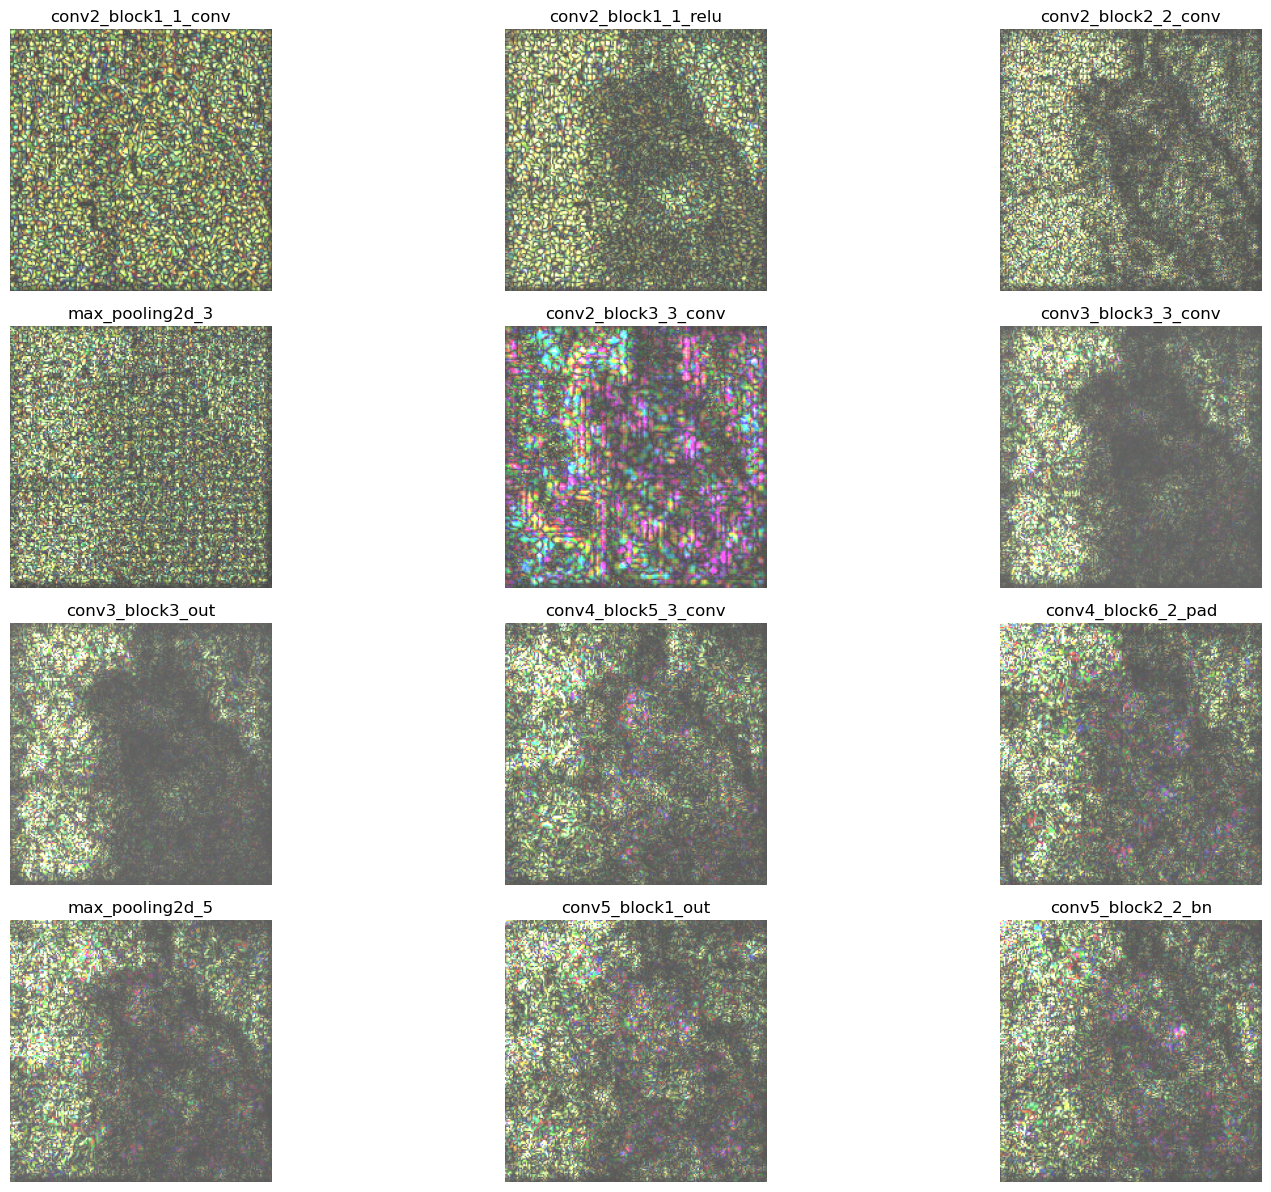

In [68]:
plt.figure(figsize=(15,15))
for i, layer in enumerate(['conv2_block1_1_conv', 'conv2_block1_1_relu', 'conv2_block2_2_conv', 'max_pooling2d_3', 'conv2_block3_3_conv', 'conv3_block3_3_conv', 'conv3_block3_out', 'conv4_block5_3_conv', 'conv4_block6_2_pad', 'max_pooling2d_5', 'conv5_block1_out', 'conv5_block2_2_bn']):
    model_out = K.mean(layer_dict[layer].output)
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(model_out, model.input)[0]

    # Normalize the gradient
    grads /= K.std(grads) + 1e-8

    # function: returns the loss and grads given the input picture
    model_predictor = K.function([model.input], [model_out, grads])
    
    # feed  the image to the network
    model_outputs, grads_values = model_predictor([img])
    
    # get the grads that have the same shape  as the input image  
    abs_grads_values = np.abs(grads_values)
    sm = tensor2image(abs_grads_values[0])
    print(sm.shape)
    plt.subplot(5,3,i+1)
    plt.imshow(sm)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()
plt.show()
    

In [104]:
for layer in model.layers:
    
    if 'conv' not in layer.name or 'pad' in layer.name or 'bn' in layer.name or 'relu' in layer.name or 'block' in layer.name:
        continue    
    print(layer.name)
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv1_conv
conv1_conv (7, 7, 3, 64)


In [108]:
model.layers[2].get_weights()

[array([[[[-1.26184434e-01,  3.86615060e-02, -2.74909362e-02, ...,
           -8.63134861e-02,  8.97451025e-03,  1.95293546e-01],
          [-1.50468409e-01, -3.11933029e-02,  4.94680703e-02, ...,
            5.08786291e-02,  1.13398749e-02,  5.65662310e-02],
          [-1.01412021e-01, -6.06461149e-03, -1.60935428e-02, ...,
            4.85567488e-02,  1.93411484e-02, -1.62903547e-01]],
 
         [[-5.86368702e-02,  4.29747738e-02, -3.49380225e-02, ...,
           -1.47739807e-02, -1.16824405e-03,  1.45855859e-01],
          [-8.65863934e-02, -3.72671224e-02,  4.27046008e-02, ...,
            2.80426368e-02, -5.11305127e-03,  6.68981746e-02],
          [-4.35088500e-02, -7.61082023e-03,  9.10499599e-03, ...,
           -7.92045984e-03,  3.31577510e-02, -8.95052776e-02]],
 
         [[ 3.47554609e-02,  2.71783099e-02, -4.54889871e-02, ...,
           -1.02716116e-02, -5.40403128e-02,  2.37635765e-02],
          [ 3.23110782e-02, -2.03066245e-02,  2.88833715e-02, ...,
            1.421

In [ ]:
layers: 2,7,11,23,38,58

(3, 128, 128)


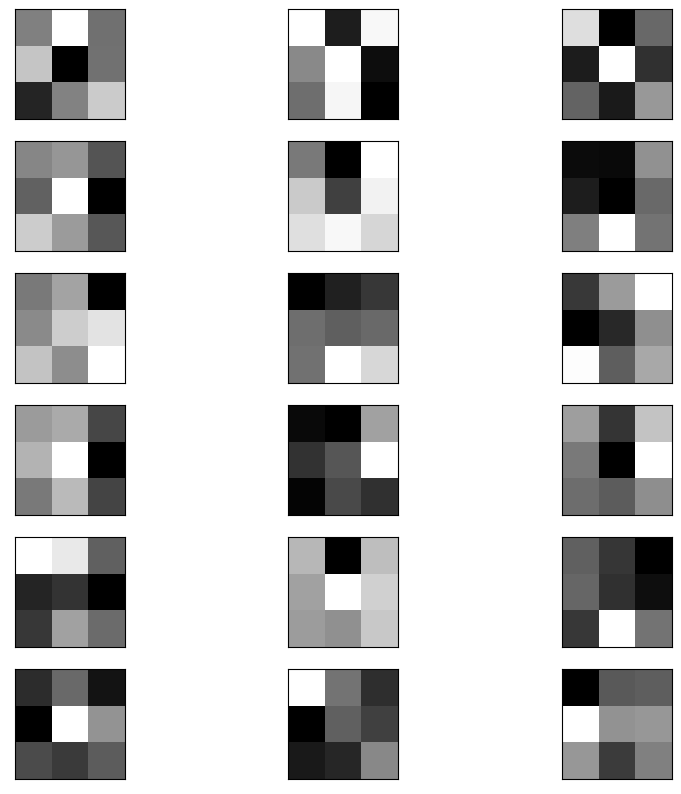

In [154]:
plt.figure(figsize=(10,10))
# display filters learned by the model
filters = model.layers[58].get_weights()[0]
print(filters[0].shape)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

4572.jpg
(373, 500, 3)
(200, 200, 3)


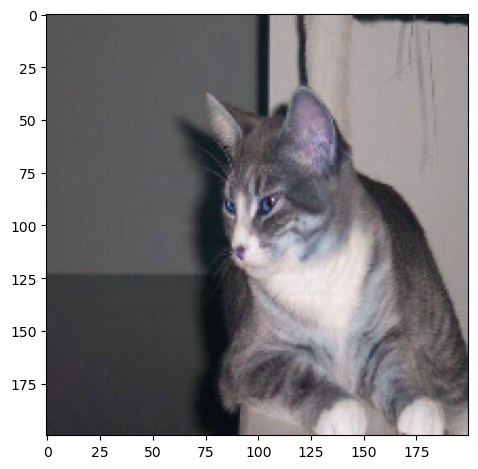

In [115]:
filename = test_df.iloc[29]['filename']
print(filename)
img1 = cv2.imread(os.path.join(TEST_DIR, filename))
print(img1.shape)
img1 = cv2.resize(img1, (200, 200))
print(img1.shape)
plt.imshow(img1)
# plt.title(label)
plt.tight_layout()
plt.show()
img = np.expand_dims(img1, axis=0)
img = preprocess_input(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(1, 100, 100, 64)


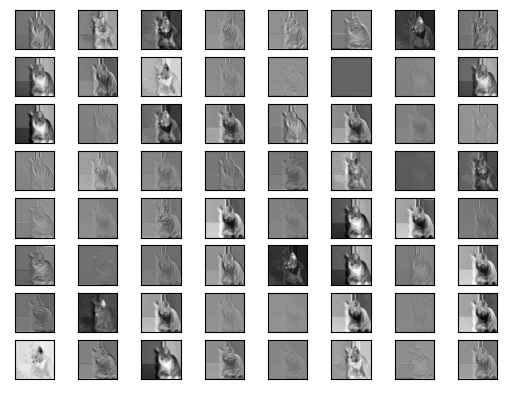

In [122]:
# visualize feature map
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[2].output)
feature_maps = model.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()


(1, 100, 100, 64)


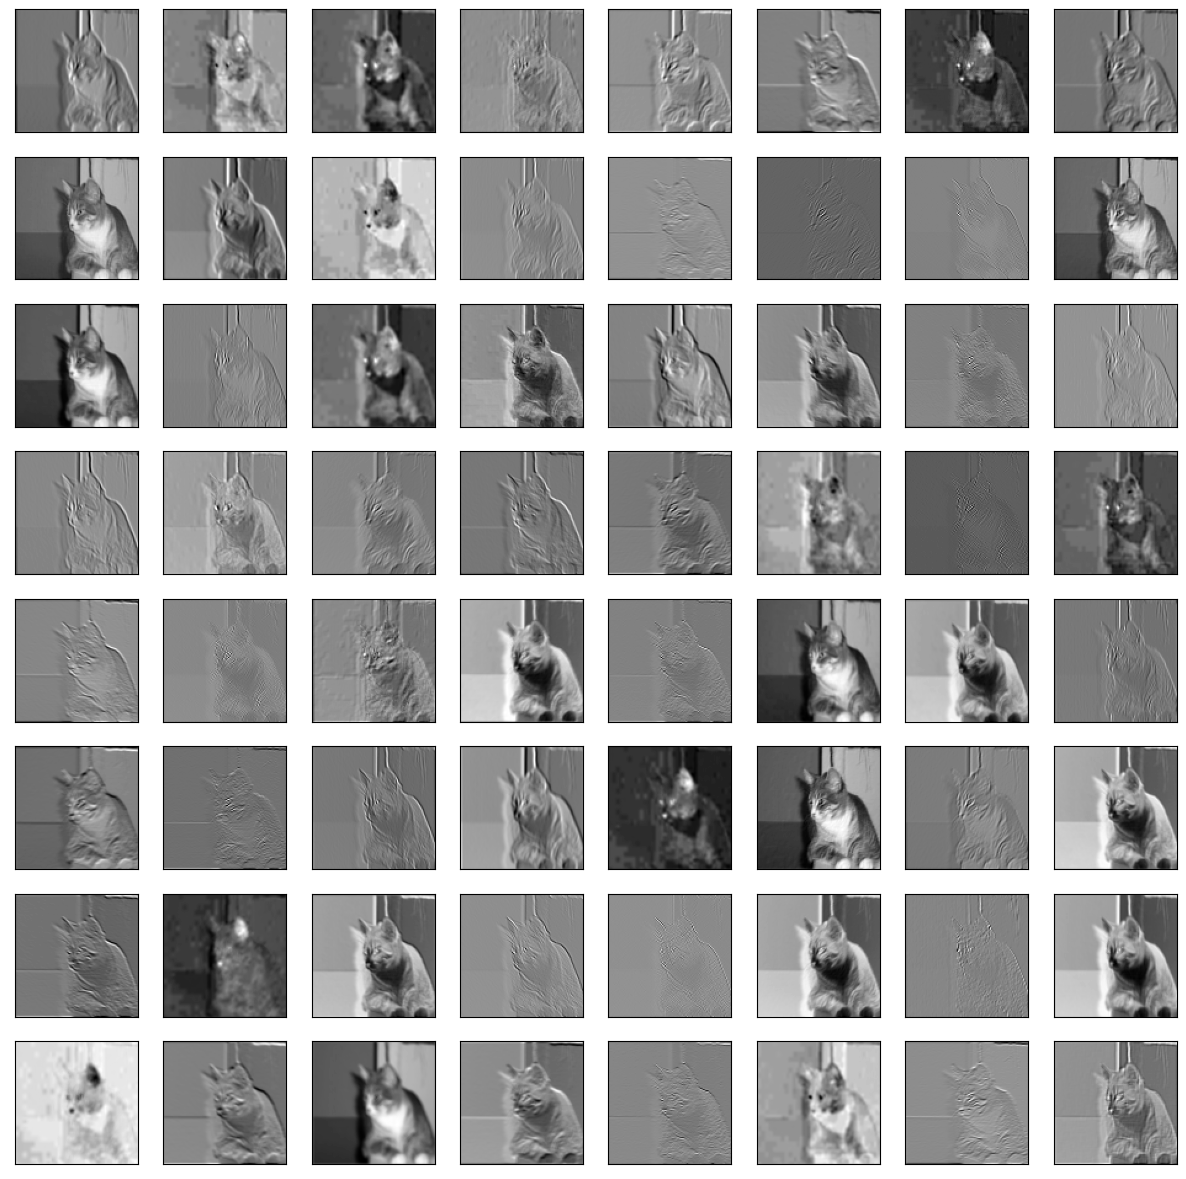

In [123]:
plt.figure(figsize=(15,15))
feature_maps = model.predict(img)
print(feature_maps.shape)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [128]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.layers[-1].output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

(1, 50, 50, 64)


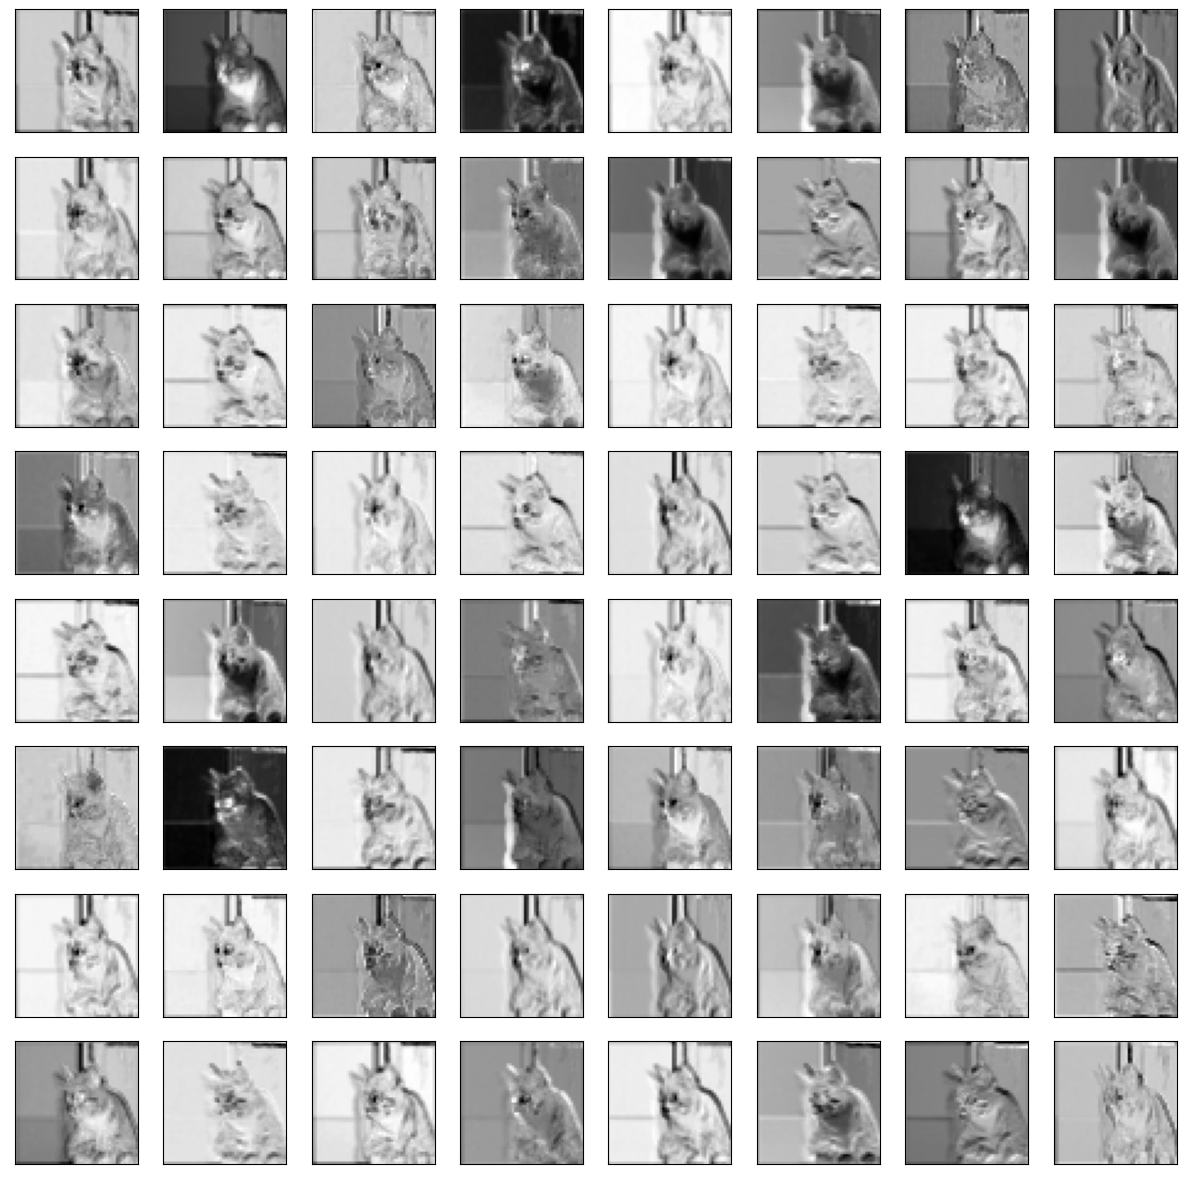

In [131]:
plt.figure(figsize=(15,15))
# visualize feature map
# redefine model to output right after the first hidden layer
model2 = Model(inputs=model.inputs, outputs=model.layers[7].output)
feature_maps = model2.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()


(1, 50, 50, 64)


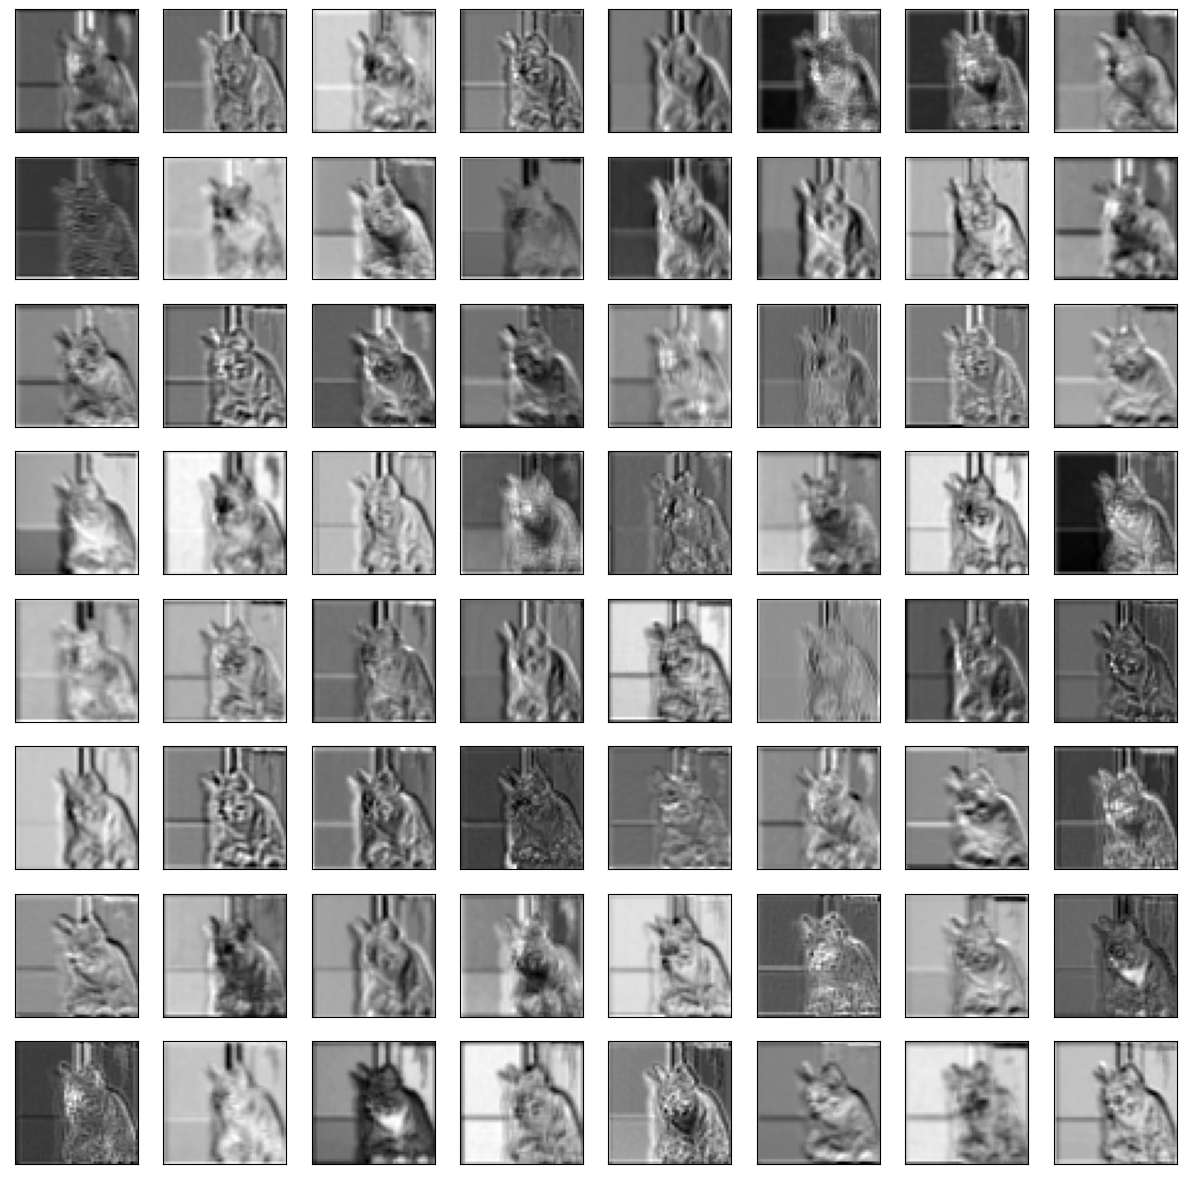

In [132]:
plt.figure(figsize=(15,15))
# visualize feature map
# redefine model to output right after the first hidden layer
model2 = Model(inputs=model.inputs, outputs=model.layers[11].output)
feature_maps = model2.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()


(1, 50, 50, 64)


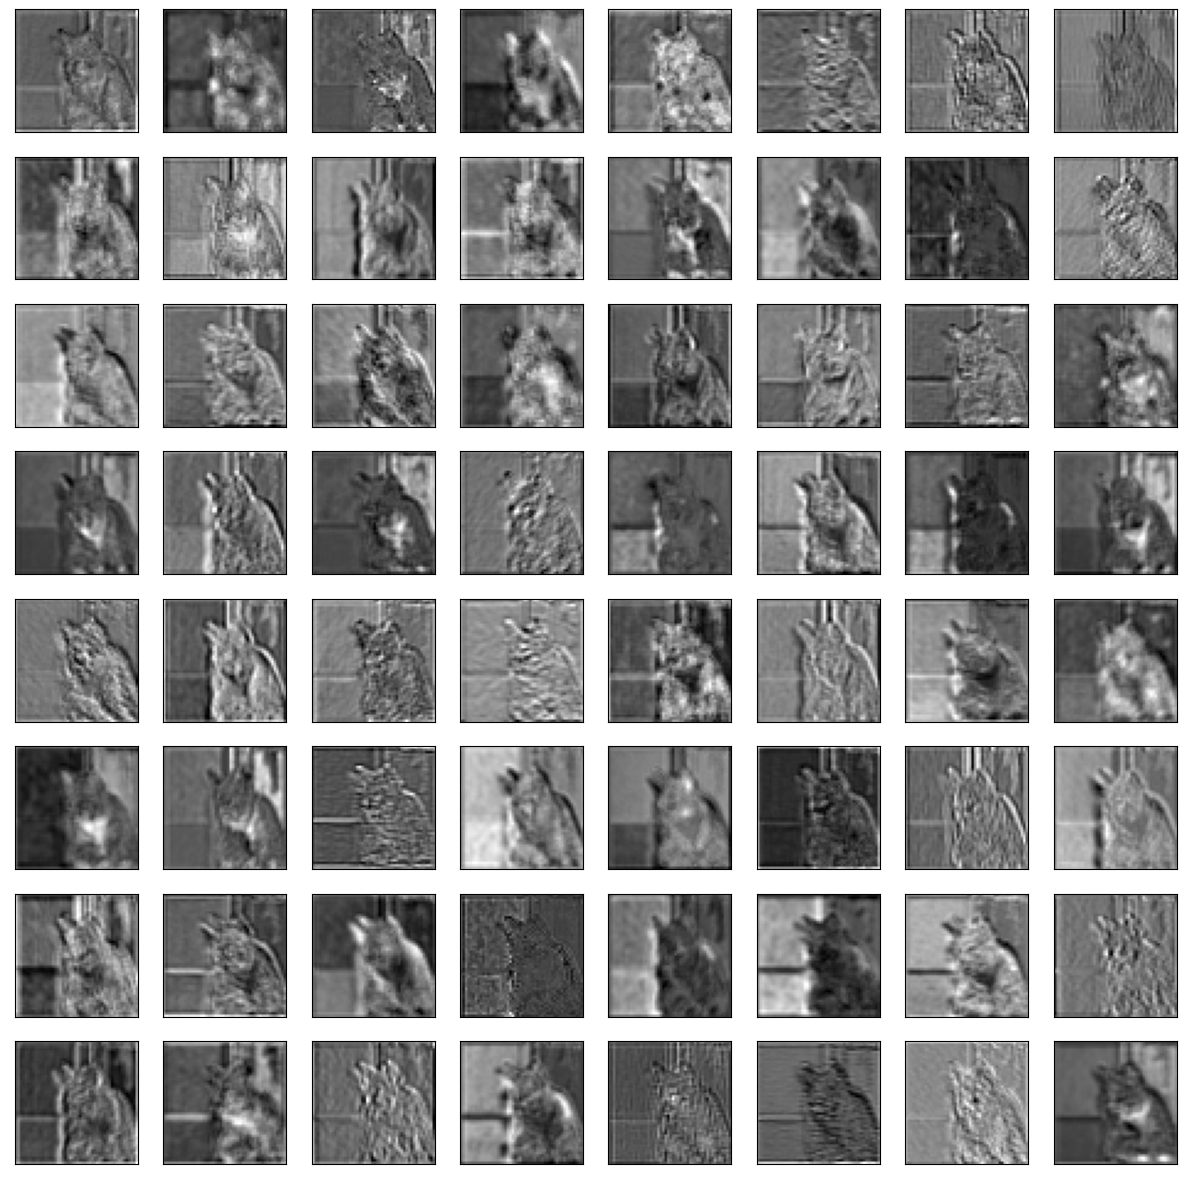

In [133]:
plt.figure(figsize=(15,15))
# visualize feature map
# redefine model to output right after the first hidden layer
model3 = Model(inputs=model.inputs, outputs=model.layers[23].output)
feature_maps = model3.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()


(1, 25, 25, 256)


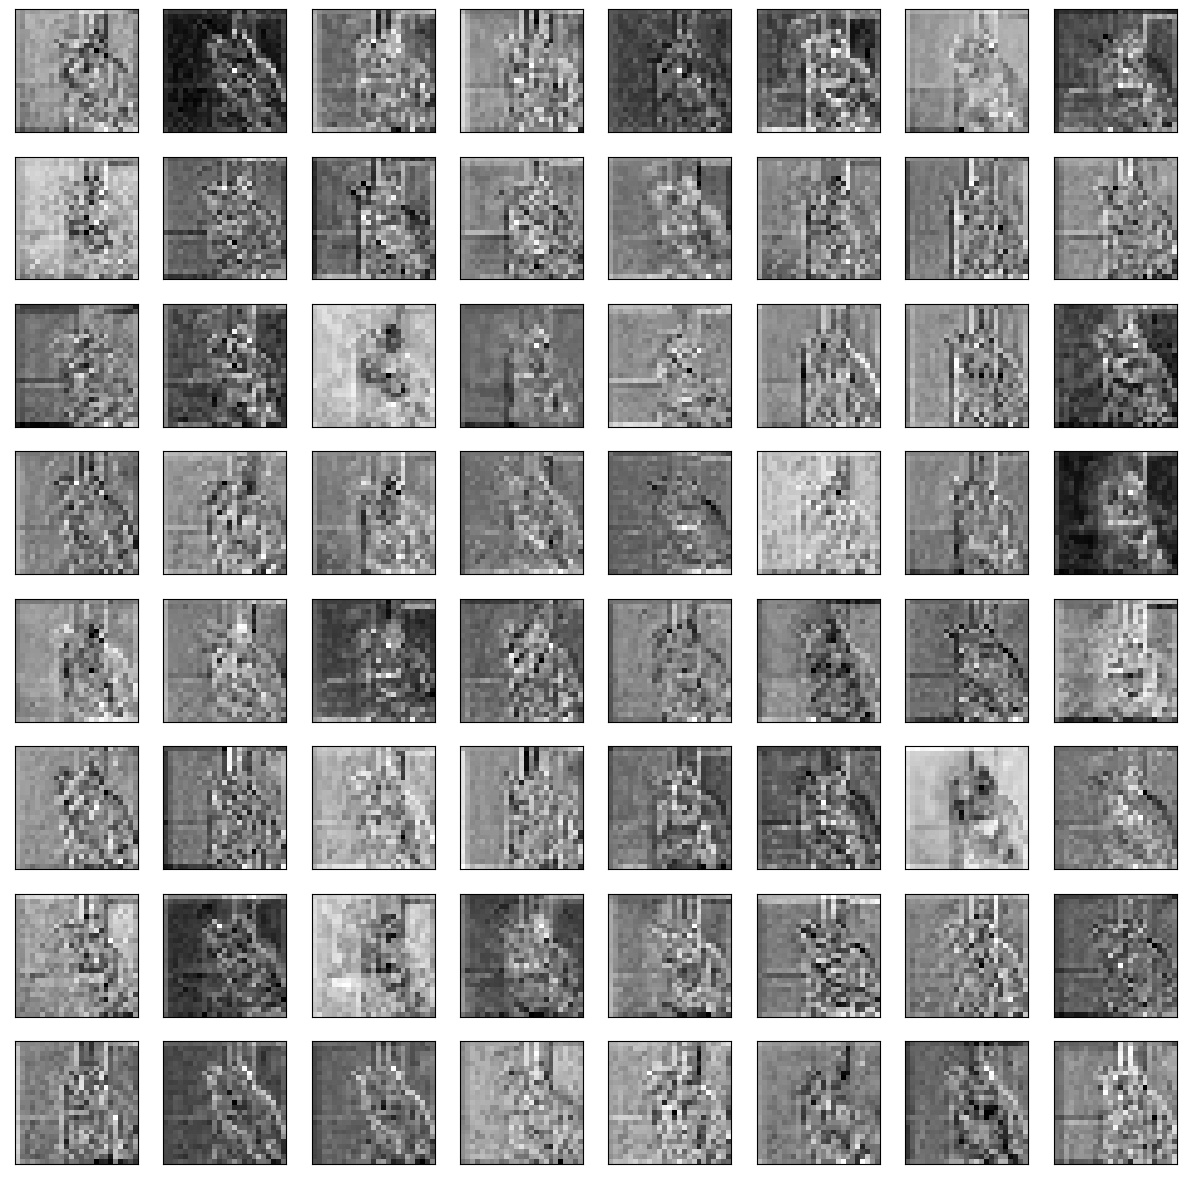

In [134]:
plt.figure(figsize=(15,15))
# visualize feature map
# redefine model to output right after the first hidden layer
model4 = Model(inputs=model.inputs, outputs=model.layers[38].output)
feature_maps = model4.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()


(1, 25, 25, 128)


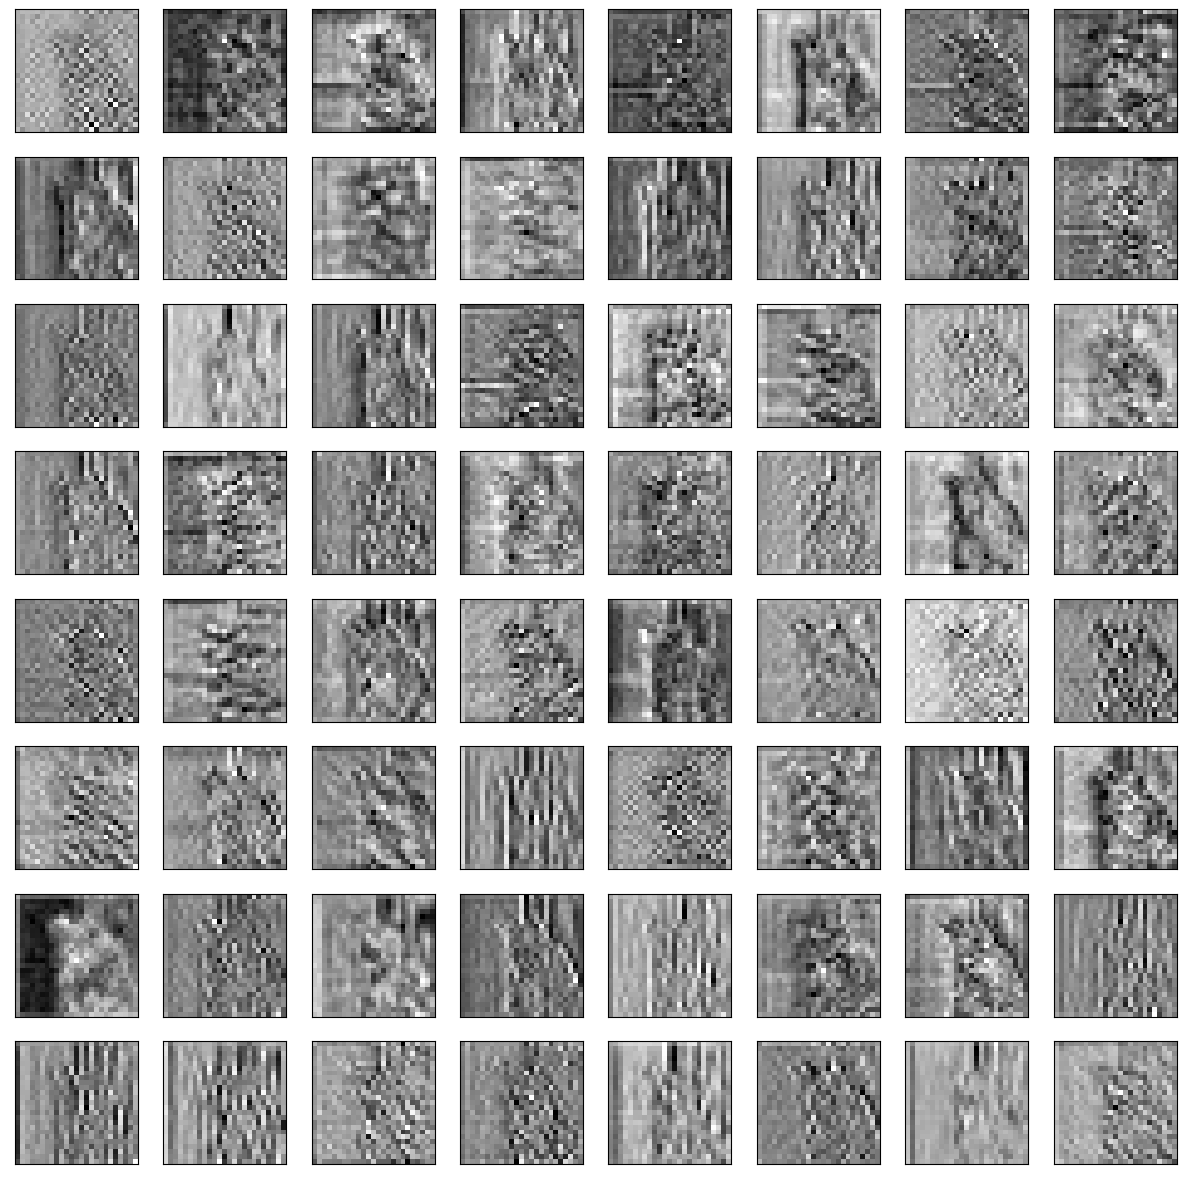

In [135]:
plt.figure(figsize=(15,15))
# visualize feature map
# redefine model to output right after the first hidden layer
model5 = Model(inputs=model.inputs, outputs=model.layers[58].output)
feature_maps = model5.predict(img)
print(feature_maps.shape)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()
